In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Step 1: Data Loading and Initial Inspection
    Load the day.csv file and get a first look at its structure.

In [2]:
df = pd.read_csv('day.csv')

print("First 5 rows of the dataset:")
print(df.head())

# Get information about the columns and data types
print("\nDataset Info:")
print(df.info())

# Basic statistics
print("\nDescriptive Statistics:")
print(df.describe())

First 5 rows of the dataset:
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

Step 2: Data Preprocessing for Time Series
Parse Date Column: Convert the 'dteday' column to datetime objects and set it as the DataFrame index.

Select Target Variable: Our target is cnt (total daily rentals).

Rename Columns (Optional but good practice): Make column names more readable.

In [3]:
# Convert 'dteday' to datetime and set as index
df['dteday'] = pd.to_datetime(df['dteday'])
df.set_index('dteday', inplace=True)

# Select relevant columns for our time series analysis
# 'cnt' is the total count of rental bikes including both registered and casual users.
# 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'
# are potential features.

ts_data = df[['cnt']].copy()

print("\nTime Series Data Info:")
print(ts_data.info())
print("\nFirst 5 rows of Time Series Data:")
print(ts_data.head())


Time Series Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cnt     731 non-null    int64
dtypes: int64(1)
memory usage: 11.4 KB
None

First 5 rows of Time Series Data:
             cnt
dteday          
2011-01-01   985
2011-01-02   801
2011-01-03  1349
2011-01-04  1562
2011-01-05  1600


Step 3: Exploratory Data Analysis (EDA) - Time Series Specific
Plot the Time Series: Visualize the cnt (total rentals) over time.

Decompose the Time Series: Separate the data into trend, seasonality, and residual components. This helps in understanding underlying patterns.

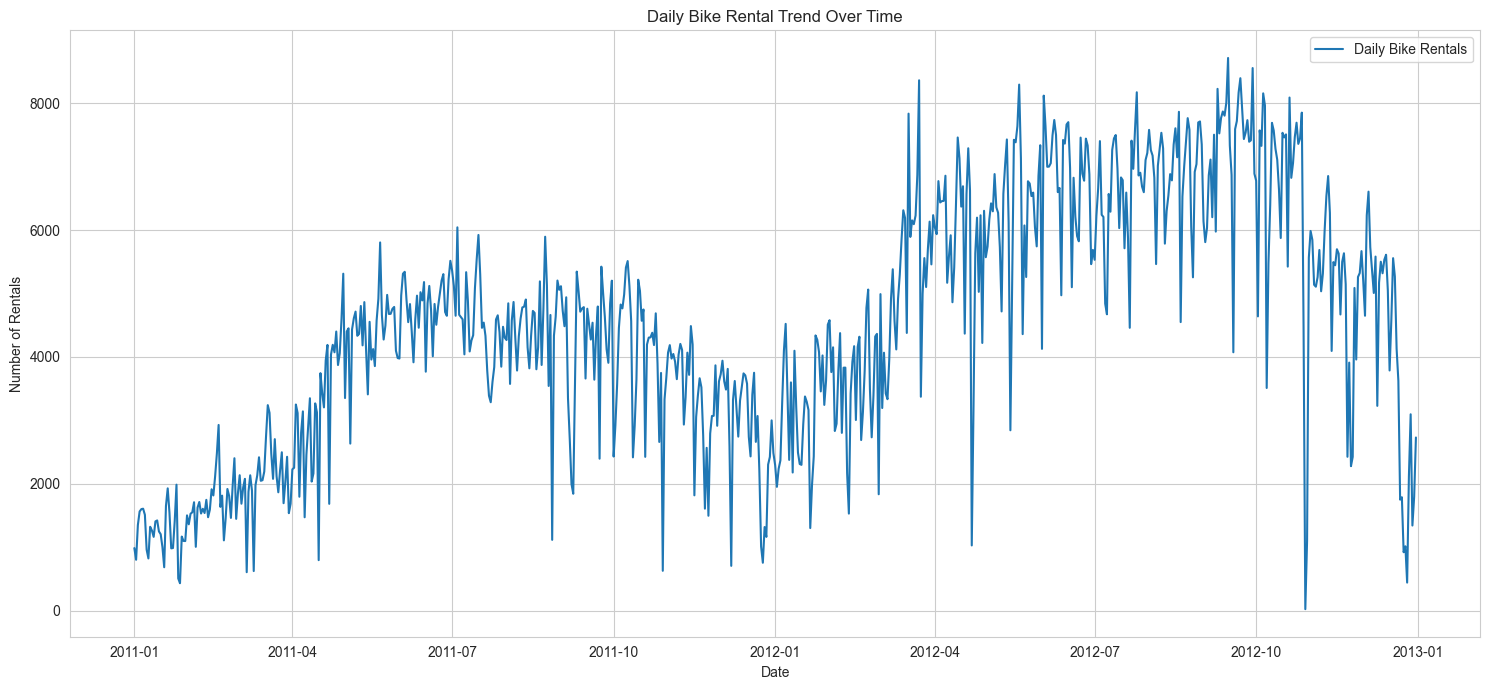

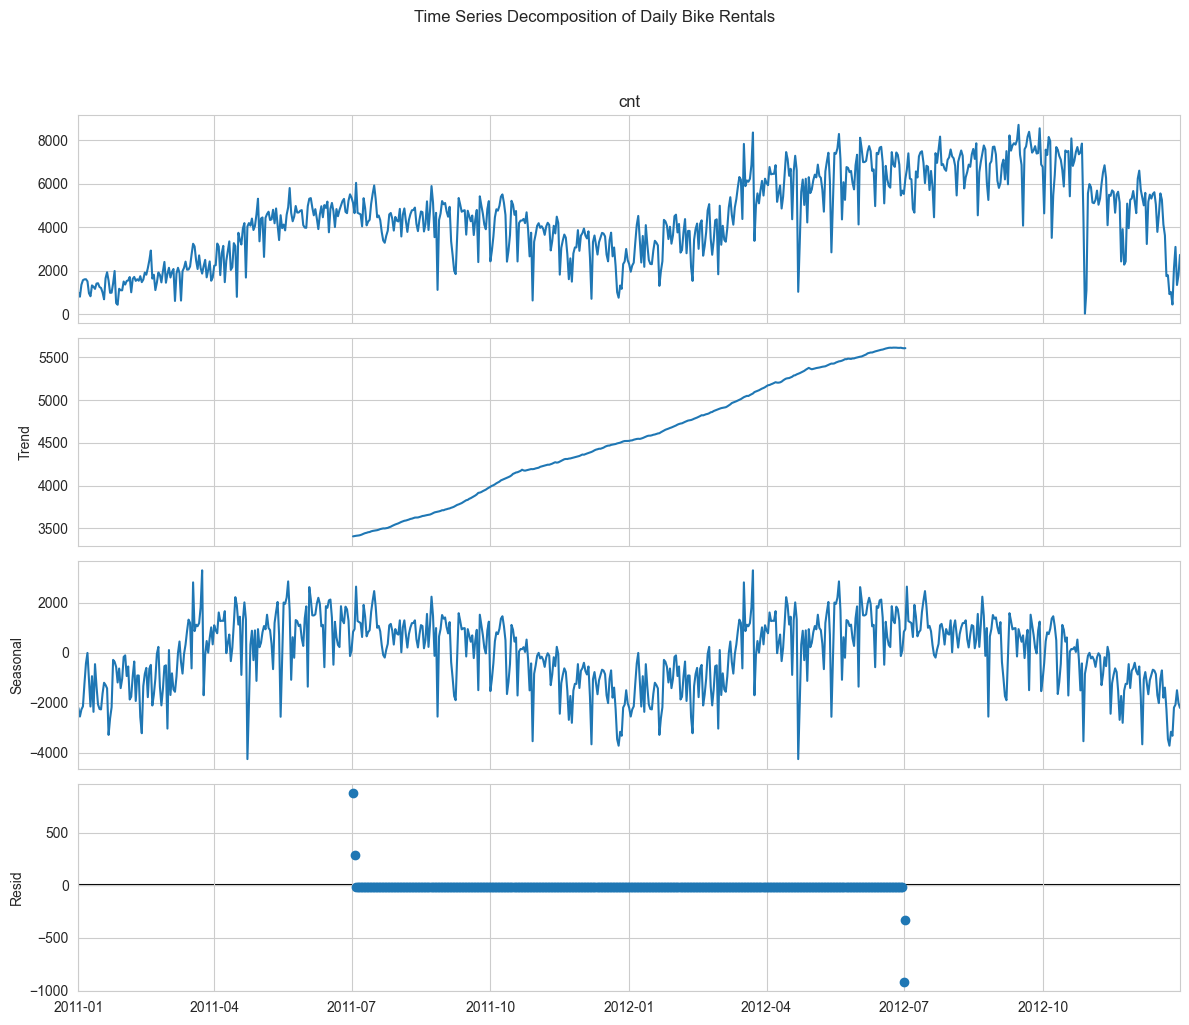

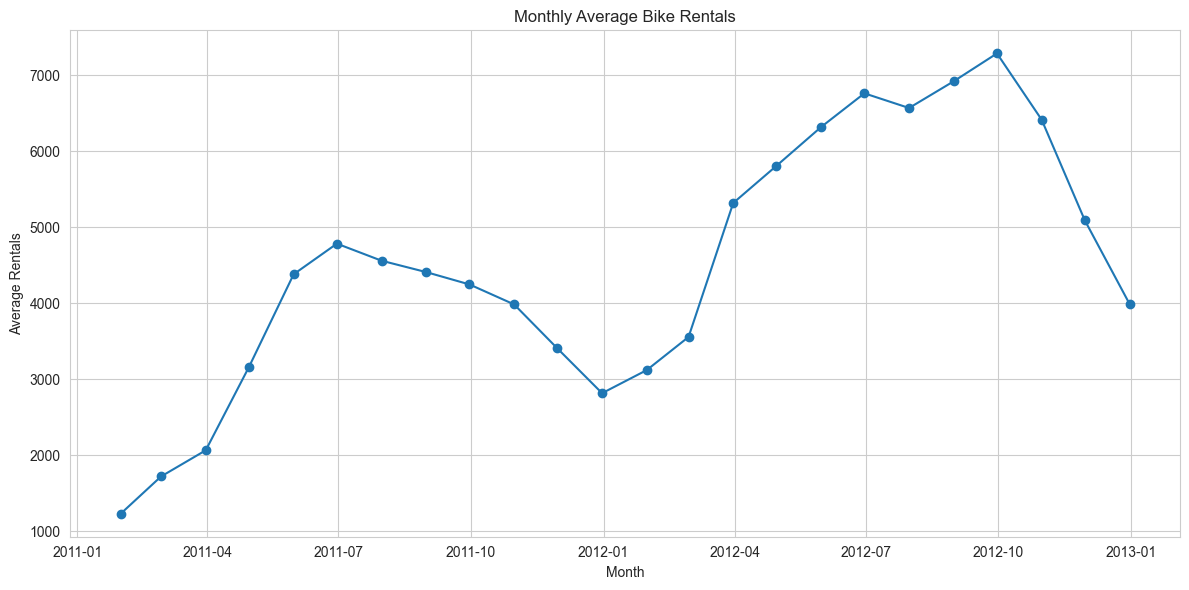

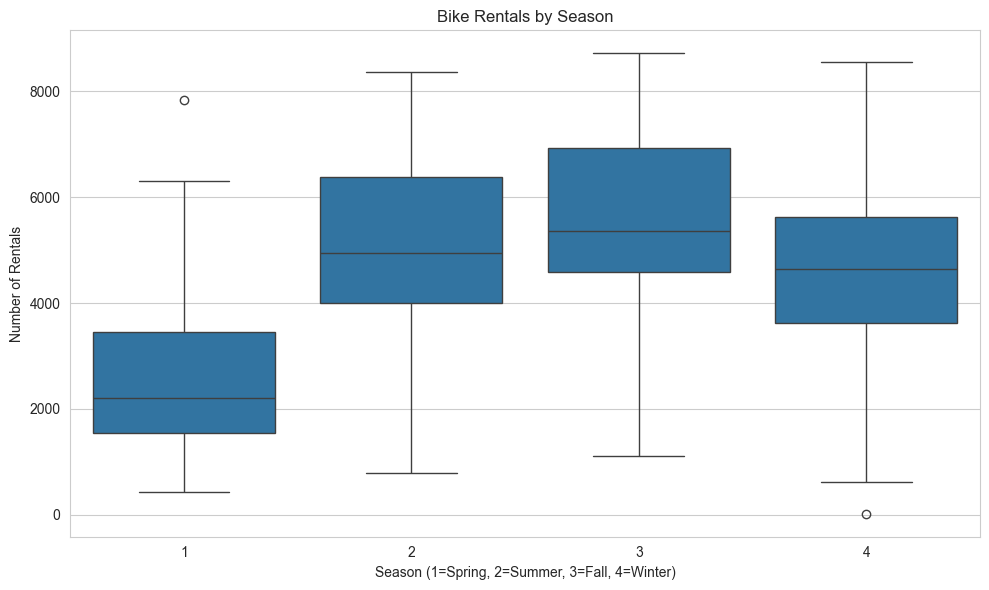

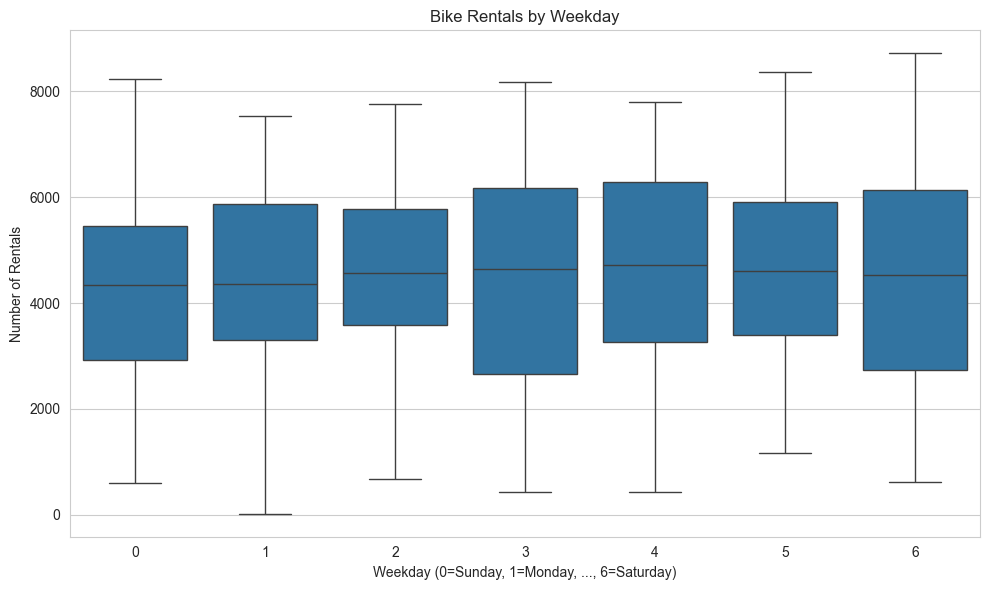

In [4]:
# 1. Plot the time series of total rentals
plt.figure(figsize=(15, 7))
plt.plot(ts_data.index, ts_data['cnt'], label='Daily Bike Rentals')
plt.title('Daily Bike Rental Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Decompose the time series (Additive Model)
# Period for decomposition: If data is daily, common periods are 7 (weekly) or 365 (yearly).
# We'll use yearly seasonality for now, as it's a prominent cycle.
# If data is less than 2 periods, decomposition might fail.
# Data spans about 2 years.
decomposition = seasonal_decompose(ts_data['cnt'], model='additive', period=365) # or period=7 for weekly
fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.suptitle('Time Series Decomposition of Daily Bike Rentals', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Observe seasonality on a smaller scale (e.g., monthly averages)
monthly_avg = ts_data['cnt'].resample('ME').mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg, marker='o')
plt.title('Monthly Average Bike Rentals')
plt.xlabel('Month')
plt.ylabel('Average Rentals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Explore impact of 'season' (1=spring, 2=summer, 3=fall, 4=winter)
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='cnt', data=df)
plt.title('Bike Rentals by Season')
plt.xlabel('Season (1=Spring, 2=Summer, 3=Fall, 4=Winter)')
plt.ylabel('Number of Rentals')
plt.tight_layout()
plt.show()

# Explore impact of 'weekday'
plt.figure(figsize=(10, 6))
sns.boxplot(x='weekday', y='cnt', data=df)
plt.title('Bike Rentals by Weekday')
plt.xlabel('Weekday (0=Sunday, 1=Monday, ..., 6=Saturday)')
plt.ylabel('Number of Rentals')
plt.tight_layout()
plt.show()

Step 4: Simple Forecasting Model
A basic approach is to use a naive forecast or a simple moving average, but we can also introduce a simple SARIMAX model without extensive parameter tuning.

Split Data: Divide into training and testing sets. A common split for time series is to use an earlier period for training and a later period for testing.

Define a Simple Forecast Model: Let's use SARIMAX as it's a powerful and versatile model. For an easy start, we'll pick some common parameters.

Train and Predict: Train the model on the training data and make predictions on the test set.

In [5]:
# Define the split point for training and testing
# Let's use the first 80% of data for training and the last 20% for testing.
train_size = int(len(ts_data) * 0.8)
train_data, test_data = ts_data[0:train_size], ts_data[train_size:]

print(f"\nTraining data points: {len(train_data)}")
print(f"Test data points: {len(test_data)}")

# Fit a simple ARIMA model for forecasting
# ARIMA order: (5, 1, 0) means AR(5), first difference, no MA component
order = (5, 1, 0) # (AR order, Differencing order, MA order)

print("\nTraining SARIMAX model...")
model = SARIMAX(train_data['cnt'], order=order, enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit(disp=False) # disp=False to suppress verbose output

print("Model training complete.")
print(model_fit.summary()) # See model summary for coefficients, etc.

# Make predictions on the test set
# For SARIMAX, use get_prediction to get confidence intervals too
forecast_steps = len(test_data)
forecast_result = model_fit.get_prediction(start=len(train_data), end=len(ts_data)-1)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int() # Confidence intervals

# Align forecast with test_data index
forecast_mean.index = test_data.index
forecast_ci.index = test_data.index

# Evaluate the model
mae = mean_absolute_error(test_data['cnt'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data['cnt'], forecast_mean))

print(f"\nMean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Training data points: 584
Test data points: 147

Training SARIMAX model...
Model training complete.
                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  584
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -4725.829
Date:                Sat, 05 Jul 2025   AIC                           9463.658
Time:                        12:59:02   BIC                           9489.816
Sample:                    01-01-2011   HQIC                          9473.858
                         - 08-06-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5401      0.036    -14.957      0.000      -0.611      -0.469
ar.L2         -0.4570      0.0

c:\Users\PRATAYA\OneDrive - iitkgp.ac.in\Desktop\BikeRental-DATA-ANALYSIS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PRATAYA\OneDrive - iitkgp.ac.in\Desktop\BikeRental-DATA-ANALYSIS\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Step 5: Visualize Forecast
Plot the actual values from the test set against your model's predictions.

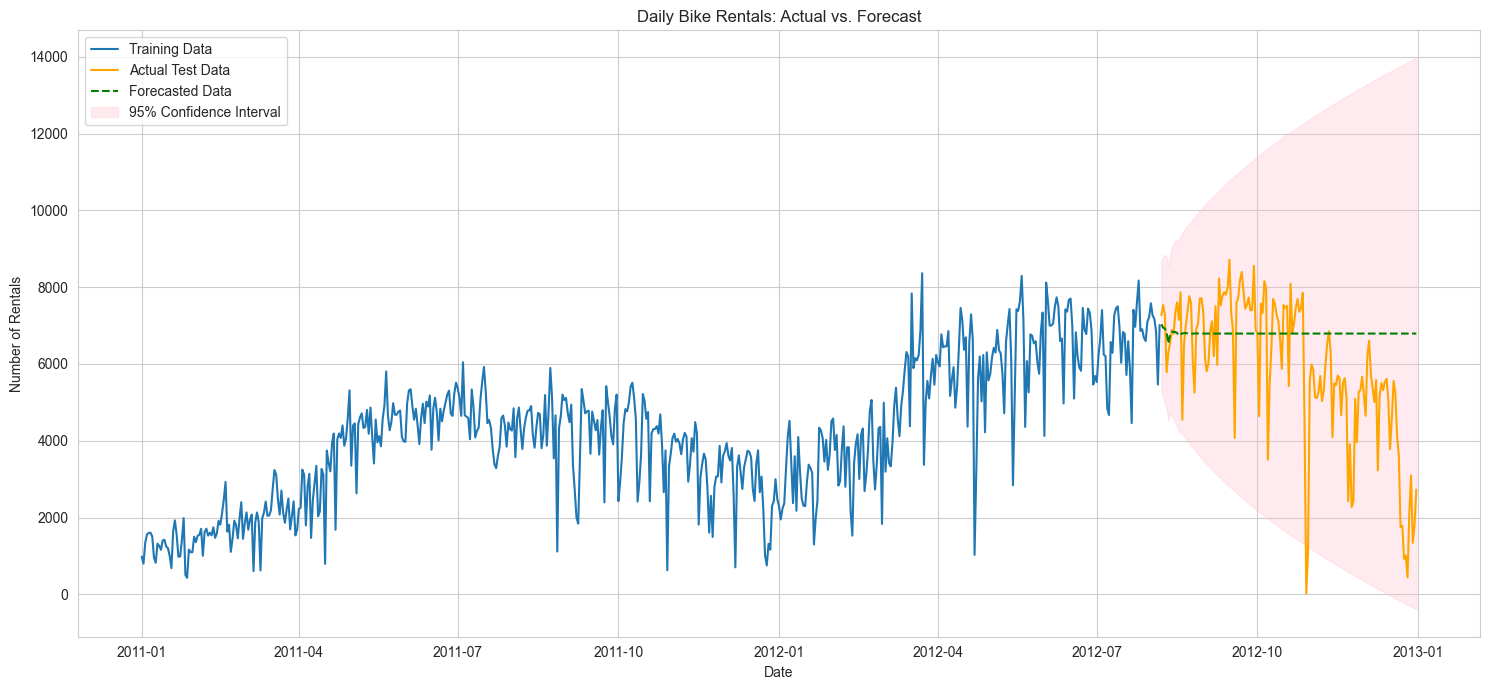

In [6]:
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data['cnt'], label='Training Data')
plt.plot(test_data.index, test_data['cnt'], label='Actual Test Data', color='orange')
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Data', color='green', linestyle='--')

# Plot confidence intervals
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Daily Bike Rentals: Actual vs. Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.tight_layout()
plt.show()